In [3]:
# import the necessary packages
import os
# initialize the path to the *original* input directory of images
ORIG_INPUT_DATASET = "histopathology dataset"
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "split data"
# derive the training, validation, and testing directories
TRAIN_PATH = os.path.sep.join([BASE_PATH, "training"])
VAL_PATH = os.path.sep.join([BASE_PATH, "validation"])
TEST_PATH = os.path.sep.join([BASE_PATH, "testing"])
# define the amount of data that will be used training
TRAIN_SPLIT = 0.8
# the amount of validation data will be a percentage of the
# *training* data
VAL_SPLIT = 0.1

In [4]:
# import the necessary packages
from imutils import paths
import random
import shutil
import os
# grab the paths to all input images in the original input directory
# and shuffle them
imagePaths = list(paths.list_images(ORIG_INPUT_DATASET))
random.seed(42)
random.shuffle(imagePaths)
# compute the training and testing split
i = int(len(imagePaths) * TRAIN_SPLIT)
trainPaths = imagePaths[:i]
testPaths = imagePaths[i:]
# we'll be using part of the training data for validation
i = int(len(trainPaths) * VAL_SPLIT)
valPaths = trainPaths[:i]
trainPaths = trainPaths[i:]
# define the datasets that we'll be building
datasets = [
	("training", trainPaths, TRAIN_PATH),
	("validation", valPaths, VAL_PATH),
	("testing", testPaths, TEST_PATH)
]
# loop over the datasets
for (dType, imagePaths, baseOutput) in datasets:
	# show which data split we are creating
	print("[INFO] building '{}' split".format(dType))
	# if the output base output directory does not exist, create it
	if not os.path.exists(baseOutput):
		print("[INFO] 'creating {}' directory".format(baseOutput))
		os.makedirs(baseOutput)
	# loop over the input image paths
	for inputPath in imagePaths:
		# extract the filename of the input image and extract the
		# class label ("0" for "negative" and "1" for "positive")
		filename = inputPath.split(os.path.sep)[-1]
		label = filename[-5:-4]
		# build the path to the label directory
		labelPath = os.path.sep.join([baseOutput, label])
		# if the label output directory does not exist, create it
		if not os.path.exists(labelPath):
			print("[INFO] 'creating {}' directory".format(labelPath))
			os.makedirs(labelPath)
		# construct the path to the destination image and then copy
		# the image itself
		p = os.path.sep.join([labelPath, filename])
		shutil.copy2(inputPath, p)

ModuleNotFoundError: No module named 'imutils'

# Feature extraction

In [2]:
# import the necessary packages
import os
# initialize the base path to the *new* directory that will contain
# our images after computing the training and testing split
BASE_PATH = "split data"
# define the names of the training, testing, and validation
# directories
TRAIN = "training"
TEST = "testing"
VAL = "validation"
# initialize the list of class label names
CLASSES = ["0", "1"]
# set the batch size'''
BATCH_SIZE = 32
# initialize the label encoder file path and the output directory to
# where the extracted features (in CSV file format) will be stored
LE_PATH = os.path.sep.join(["split csv", "le.cpickle"])
BASE_CSV_PATH = "split csv"

In [3]:
''# import the necessary packages
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from imutils import paths
import numpy as np
import pickle
import random
import os
# load the ResNet50 network and initialize the label encoder
print("[INFO] loading network...")
model = ResNet50(weights="imagenet", include_top=False)
le = None
# loop over the data splits
for split in (TRAIN, TEST, VAL):
	# grab all image paths in the current split
	print("[INFO] processing '{} split'...".format(split))
	p = os.path.sep.join([BASE_PATH, split])
	imagePaths = list(paths.list_images(p))
	# randomly shuffle the image paths and then extract the class
	# labels from the file paths
	random.shuffle(imagePaths)
	labels = [p.split(os.path.sep)[-2] for p in imagePaths]
	# if the label encoder is None, create it
	if le is None:
		le = LabelEncoder()
		le.fit(labels)
	# open the output CSV file for writing
	csvPath = os.path.sep.join([BASE_CSV_PATH,
		"{}.csv".format(split)])
	csv = open(csvPath, "w")
    # loop over the images in batches
	for (b, i) in enumerate(range(0, len(imagePaths), BATCH_SIZE)):
		# extract the batch of images and labels, then initialize the
		# list of actual images that will be passed through the network
		# for feature extraction
		print("[INFO] processing batch {}/{}".format(b + 1,
			int(np.ceil(len(imagePaths) / float(BATCH_SIZE)))))
		batchPaths = imagePaths[i:i + BATCH_SIZE]
		batchLabels = le.transform(labels[i:i + BATCH_SIZE])
		batchImages = []
		# loop over the images and labels in the current batch
		for imagePath in batchPaths:
			# load the input image using the Keras helper utility
			# while ensuring the image is resized to 224x224 pixels
			image = load_img(imagePath, target_size=(224, 224))
			image = img_to_array(image)
			# preprocess the image by (1) expanding the dimensions and
			# (2) subtracting the mean RGB pixel intensity from the
			# ImageNet dataset
			image = np.expand_dims(image, axis=0)
			image = preprocess_input(image)
			# add the image to the batch
			batchImages.append(image)
            	# pass the images through the network and use the outputs as
		# our actual features, then reshape the features into a
		# flattened volume
		batchImages = np.vstack(batchImages)
		features = model.predict(batchImages, batch_size=BATCH_SIZE)
		features = features.reshape((features.shape[0], 7 * 7 * 2048))
		# loop over the class labels and extracted features
		for (label, vec) in zip(batchLabels, features):
			# construct a row that exists of the class label and
			# extracted features
			vec = ",".join([str(v) for v in vec])
			csv.write("{},{}\n".format(label, vec))
	# close the CSV file
	csv.close()
# serialize the label encoder to disk
f = open(LE_PATH, "wb")
f.write(pickle.dumps(le))
f.close()''

ModuleNotFoundError: No module named 'sklearn'

# Feature selection and classification

In [3]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier


# error rate
def error_rate(xtrain, ytrain, x, opts):
    # parameters
    k     = opts['k']
    fold  = opts['fold']
    xt    = fold['xt']
    yt    = fold['yt']
    xv    = fold['xv'] 
    yv    = fold['yv']
    
    # Number of instances
    num_train = np.size(xt, 0)
    num_valid = np.size(xv, 0)
    # Define selected features
    xtrain  = xt[:, x == 1]
    ytrain  = yt.reshape(num_train)  # Solve bug
    xvalid  = xv[:, x == 1]
    yvalid  = yv.reshape(num_valid)  # Solve bug   
    # Training
    mdl     = KNeighborsClassifier(n_neighbors = k)
    mdl.fit(xtrain, ytrain)
    # Prediction
    ypred   = mdl.predict(xvalid)
    acc     = np.sum(yvalid == ypred) / num_valid
    error   = 1 - acc
    
    return error


# Error rate & Feature size
def Fun(xtrain, ytrain, x, opts):
    # Parameters
    alpha    = 0.99
    beta     = 1 - alpha
    # Original feature size
    max_feat = len(x)
    # Number of selected features
    num_feat = np.sum(x == 1)
    # Solve if no feature selected
    if num_feat == 0:
        cost  = 1
    else:
        # Get error rate
        error = error_rate(xtrain, ytrain, x, opts)
        # Objective function
        cost  = alpha * error + beta * (num_feat / max_feat)
        
    return cost


In [4]:
import numpy as np
from numpy.random import rand

def init_position(lb, ub, N, dim):
    X = np.zeros([N, dim], dtype='float')
    for i in range(N):
        for d in range(dim):
            X[i,d] = lb[0,d] + (ub[0,d] - lb[0,d]) * rand()        
    
    return X


def init_velocity(lb, ub, N, dim):
    V    = np.zeros([N, dim], dtype='float')
    Vmax = np.zeros([1, dim], dtype='float')
    Vmin = np.zeros([1, dim], dtype='float')
    # Maximum & minimum velocity
    for d in range(dim):
        Vmax[0,d] = (ub[0,d] - lb[0,d]) / 2
        Vmin[0,d] = -Vmax[0,d]
        
    for i in range(N):
        for d in range(dim):
            V[i,d] = Vmin[0,d] + (Vmax[0,d] - Vmin[0,d]) * rand()
        
    return V, Vmax, Vmin


def binary_conversion(X, thres, N, dim):
    Xbin = np.zeros([N, dim], dtype='int')
    for i in range(N):
        for d in range(dim):
            if X[i,d] > thres:
                Xbin[i,d] = 1
            else:
                Xbin[i,d] = 0
    
    return Xbin


def boundary(x, lb, ub):
    if x < lb:
        x = lb
    if x > ub:
        x = ub
    
    return x
    

def jfs(xtrain, ytrain, opts):
    # Parameters
    ub    = 1
    lb    = 0
    thres = 0.5
    w     = 0.9    # inertia weight
    c1    = 2      # acceleration factor
    c2    = 2      # acceleration factor
    
    N        = opts['N']
    max_iter = opts['T']
    if 'w' in opts:
        w    = opts['w']
    if 'c1' in opts:
        c1   = opts['c1']
    if 'c2' in opts:
        c2   = opts['c2'] 
    
    # Dimension
    dim = np.size(xtrain, 1)
    if np.size(lb) == 1:
        ub = ub * np.ones([1, dim], dtype='float')
        lb = lb * np.ones([1, dim], dtype='float')
        
    # Initialize position & velocity
    X             = init_position(lb, ub, N, dim)
    V, Vmax, Vmin = init_velocity(lb, ub, N, dim) 
    
    # Pre
    fit   = np.zeros([N, 1], dtype='float')
    Xgb   = np.zeros([1, dim], dtype='float')
    fitG  = float('inf')
    Xpb   = np.zeros([N, dim], dtype='float')
    fitP  = float('inf') * np.ones([N, 1], dtype='float')
    curve = np.zeros([1, max_iter], dtype='float') 
    t     = 0
    
    while t < max_iter:
        # Binary conversion
        Xbin = binary_conversion(X, thres, N, dim)
        
        # Fitness
        for i in range(N):
            fit[i,0] = Fun(xtrain, ytrain, Xbin[i,:], opts)
            if fit[i,0] < fitP[i,0]:
                Xpb[i,:]  = X[i,:]
                fitP[i,0] = fit[i,0]
            if fitP[i,0] < fitG:
                Xgb[0,:]  = Xpb[i,:]
                fitG      = fitP[i,0]
        
        # Store result
        curve[0,t] = fitG.copy()
        print("Iteration:", t + 1)
        print("Best (PSO):", curve[0,t])
        t += 1
        
        for i in range(N):
            for d in range(dim):
                # Update velocity
                r1     = rand()
                r2     = rand()
                V[i,d] = w * V[i,d] + c1 * r1 * (Xpb[i,d] - X[i,d]) + c2 * r2 * (Xgb[0,d] - X[i,d]) 
                # Boundary
                V[i,d] = boundary(V[i,d], Vmin[0,d], Vmax[0,d])
                # Update position
                X[i,d] = X[i,d] + V[i,d]
                # Boundary
                X[i,d] = boundary(X[i,d], lb[0,d], ub[0,d])
    
                
    # Best feature subset
    Gbin       = binary_conversion(Xgb, thres, 1, dim) 
    Gbin       = Gbin.reshape(dim)
    pos        = np.asarray(range(0, dim))    
    sel_index  = pos[Gbin == 1]
    num_feat   = len(sel_index)
    # Create dictionary
    pso_data = {'sf': sel_index, 'c': curve, 'nf': num_feat}
    
    return pso_data    


Iteration: 1
Best (PSO): 0.05356668522932365
Iteration: 2
Best (PSO): 0.047501436216548606
Iteration: 3
Best (PSO): 0.047501436216548606
Iteration: 4
Best (PSO): 0.04740676850023287
Iteration: 5
Best (PSO): 0.04730253436205786
Iteration: 6
Best (PSO): 0.047221120126026334
Iteration: 7
Best (PSO): 0.047221120126026334
Iteration: 8
Best (PSO): 0.047221120126026334
Iteration: 9
Best (PSO): 0.047221120126026334
Iteration: 10
Best (PSO): 0.047221120126026334
The number of features selected : 47223


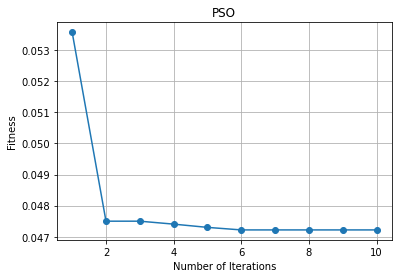

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt


# load data
data  = pd.read_csv('E:/PROJECT/split csv/training.csv')
data  = data.values
feat  = np.asarray(data[:, 1:-1])
label = np.asarray(data[:, 0])

# split data into train & validation 80 --20)
xtrain, xtest, ytrain, ytest = train_test_split(feat, label, test_size=0.2, stratify=label)
fold = {'xt':xtrain, 'yt':ytrain, 'xv':xtest, 'yv':ytest}

# parameter
k    = 5    # k-value in KNN
N    = 10    # number of particles
T    = 10   # maximum number of iterations
opts = {'k':k, 'fold':fold, 'N':N, 'T':T}

# perform feature selection
fmdl = jfs(feat, label, opts)
sf   = fmdl['sf']

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

# number of selected features
num_feat = fmdl['nf']
print("The number of features selected :", num_feat)

# plot convergence
curve   = fmdl['c']
curve   = curve.reshape(np.size(curve,1))
x       = np.arange(0, opts['T'], 1.0) + 1.0
fig, ax = plt.subplots()
ax.plot(x, curve, 'o-')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Fitness')
ax.set_title('PSO')
ax.grid()
plt.show()

Accuracy : 97.546
Precision : 97.826
Recall : 93.750
F1-score : 95.745
Sensitivity :  99.1304347826087
Specificity :  93.75


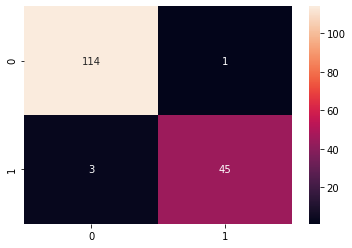

In [6]:
from sklearn import svm
from sklearn.metrics import confusion_matrix,precision_score, f1_score, recall_score,plot_confusion_matrix
import seaborn as sns
from sklearn.pipeline import Pipeline

# model with selected features
num_train = np.size(xtrain, 0)
num_valid = np.size(xtest, 0)
x_train   = xtrain[:, sf]
y_train   = ytrain.reshape(num_train)  # Solve bug
x_valid   = xtest[:, sf]
y_valid   = ytest.reshape(num_valid)  # Solve bug

mdl = svm.SVC(kernel='linear')
mdl.fit(x_train, y_train)

# accuracy
y_pred    = mdl.predict(x_valid)
Acc= (np.sum(y_valid==y_pred) / num_valid)*100
print("Accuracy : %.3f" % Acc)

Precision=precision_score(y_valid,y_pred)*100
print("Precision : %.3f" % Precision)

Recall=recall_score(y_valid,y_pred)*100
print("Recall : %.3f" % Recall)

F1=f1_score(y_valid,y_pred)*100
print("F1-score : %.3f" % F1)

cm = confusion_matrix(y_valid, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')
total1=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])*100
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])*100
print('Specificity : ', specificity)


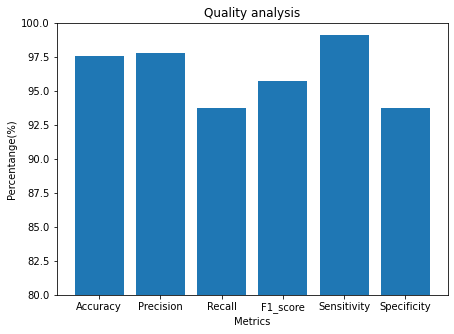

In [7]:
x = ['Accuracy', 'Precision', 'Recall', 'F1_score','Sensitivity','Specificity']
y= [Acc,Precision,Recall,F1,sensitivity,specificity]
fig=plt.figure(figsize=(7,5))
plt.ylim(80,100)
plt.bar(x, y)
plt.title('Quality analysis')
plt.xlabel('Metrics')
plt.ylabel('Percentange(%)')

# Displaying the bar plot
plt.show()
             